# Collecte the Data

### import the libraries needed for data collection and web scraping

In [45]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

### The function below allows to retrieve the urls of the issues and returns a list of these urls

In [46]:
def get_all_pages(url):
    response = requests.get(url)
    url_issues = []
    if response.ok: 
        soup = BeautifulSoup(response.text, 'html.parser')
        a = soup.find_all('em',"current")
        nb_pages = int(a[0].get("data-total-pages"))
    for i in range(1, nb_pages+1):
        page = "https://github.com/rails/rails/issues?page="+str(i)+"&q=is%3Aissue+is%3Aopen"
        response = requests.get(page)
        if response.ok:
            soup = BeautifulSoup(response.text, 'html.parser')
            url_issues += [x.get('href') for x in soup.find_all('a',"d-block d-md-none position-absolute top-0 bottom-0 left-0 right-0")]
    return url_issues

### this function takes as argument the url of an issue, then it browses the page which contains information on this issue such as the number of comments, the author ... and returns this information

In [47]:
def get_info_issue(url):
    url_issue = 'https://github.com'+url
    response = requests.get(url_issue)
    if response.ok: 
        soup = BeautifulSoup(response.text, 'html.parser')
        name_issue = soup.find_all('span',"js-issue-title markdown-title")[0].string
        author_issue = soup.find_all('a',"author text-bold Link--secondary")[0].string
        date_issue = soup.find('relative-time',"no-wrap").text
        number_of_comments = int(soup.find('div',"flex-auto min-width-0 mb-2").text.split(sep=" ", maxsplit=10)[7])
        issue_labels = np.unique([x.get('data-name') for x in soup.find_all('a', 'IssueLabel hx_IssueLabel width-fit mb-1 mr-1')]).tolist()
        number_of_participants = int(soup.find('div', 'participation').text.split(sep=" ", maxsplit=10)[6])
    return name_issue, author_issue, date_issue, number_of_comments, issue_labels, number_of_participants

In [48]:
list_url_issues = get_all_pages('https://github.com/rails/rails/issues')

### we loop over the list of urls and apply the function get_info_issue and generate all the lists that contain the information about all the isuues

In [49]:
list_of_names = []
list_of_authors = []
list_of_dates = []
list_of_number_of_comments = []
list_of_labels = []
list_of_number_of_participants = []

for url in list_url_issues:
    name_issue, author_issue, date_issue, number_of_comments, issue_labels, number_of_participants = get_info_issue(url)
    list_of_names.append(name_issue)
    list_of_authors.append(author_issue)
    list_of_dates.append(date_issue)
    list_of_number_of_comments.append(number_of_comments)
    list_of_labels.append(issue_labels)
    list_of_number_of_participants.append(number_of_participants)

In [50]:
# Function to convert a list of strings to one string
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

# Structure and clean up the names of the issues
labels = []
for i in range(len(list_of_names)):
    if list_of_names[i] != None:
        list_of_names[i] = list_of_names[i].replace('\n', '')
        list_of_names[i] = list_of_names[i].replace(' ', '')
    labels.append(listToString(list_of_labels[i]))

### Save our data in a csv file

In [51]:
df = pd.DataFrame(list(zip(list_of_names, list_of_authors, list_of_dates, list_of_number_of_comments, labels, list_of_number_of_participants)), columns =['issue name', 'author', 'date', 'number of comments', 'labels', 'number of participants'])

In [52]:
df.to_csv('data.csv', index=False, sep=';')

# Analyze the Data

### Import the libraries that allow you to analyze and visualize the data we have collected

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

## How do the number of issues evolve across time?

### Sum the number of issues per year

In [54]:
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
number_of_issues = []
for year in years:
    i=0
    for date in list_of_dates:
        if year in date :
            i += 1
    number_of_issues.append(i)

In [55]:
df = pd.DataFrame(list(zip(years, number_of_issues)), columns = ['year', 'number of issues'])

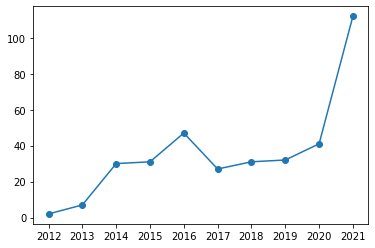

In [56]:
plt.plot( 'year', 'number of issues', data=df, linestyle='-', marker='o')
plt.show()

## Are there any periods in which we get more issues?

### Sum the number of issues per month

In [57]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
number_of_issues = []
for month in months:
    i=0
    for date in list_of_dates:
        if month in date :
            i += 1
    number_of_issues.append(i)

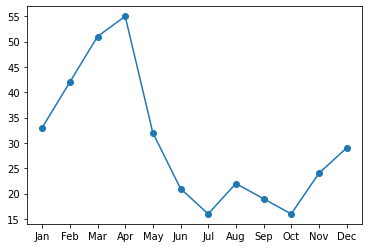

In [58]:
df = pd.DataFrame(list(zip(months, number_of_issues)), columns = ['month', 'number of issues'])
plt.plot( 'month', 'number of issues', data=df, linestyle='-', marker='o')
plt.show()

## Is there anyone who reports more issues than others?

In [59]:
authors = np.unique(list_of_authors).tolist()

In [60]:
number_of_issues = []
for author in authors:
    i=0
    for aut in list_of_authors:
        if author == aut :
            i += 1
    number_of_issues.append(i)

In [61]:
top_5_idx = np.argsort(number_of_issues)[-5:]
top_5_issues = [number_of_issues[i] for i in top_5_idx]
top_5_authors = [authors[i] for i in top_5_idx]

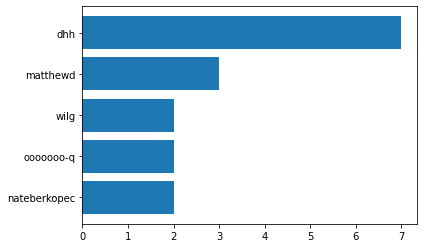

In [62]:
y_pos = np.arange(len(top_5_authors))
plt.barh(y_pos, top_5_issues)
plt.yticks(y_pos, top_5_authors)
plt.show()

## What is the most popular category (label)? 

In [63]:
all_labels = [j for sub in list_of_labels for j in sub]

In [64]:
labels = np.unique(all_labels).tolist()

In [65]:
number_of_label = []
for label in labels:
    i=0
    for lab in all_labels:
        if label == lab :
            i += 1
    number_of_label.append(i)

###  Have the top 5 labels that have been used the most

In [66]:
top_5_idx = np.argsort(number_of_label)[-5:]
top_5_number_labels = [number_of_label[i] for i in top_5_idx]
top_5_labels = [labels[i] for i in top_5_idx]

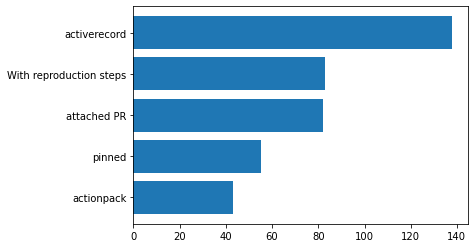

In [67]:
y_pos = np.arange(len(top_5_labels))
plt.barh(y_pos, top_5_number_labels)
plt.yticks(y_pos, top_5_labels)
plt.show()

## Suggestion :  Issues that had the more participants

In [34]:
top_5_idx = np.argsort(list_of_number_of_comments)[-5:]
top_5_list_of_number_of_participants = [list_of_number_of_participants[i] for i in top_5_idx]
top_5_list_of_names = [list_of_names[i] for i in top_5_idx]

In [37]:
df = pd.DataFrame(list(zip(top_5_list_of_names, top_5_list_of_number_of_participants)), columns = ['issue', 'number of participants'])

In [38]:
df

,issue,number of participants
0,render_to_stringchangescontent-typeforsubseque...,22
1,Rack::ETagmiddlewaredoesn'tplaynicewithLivestr...,10
2,NoMethodError-undefinedmethod`build'onActiveRe...,7
3,Livestreamingthreadsnotdying,36
4,accepts_nested_attributes_forbreakstheuniquene...,47


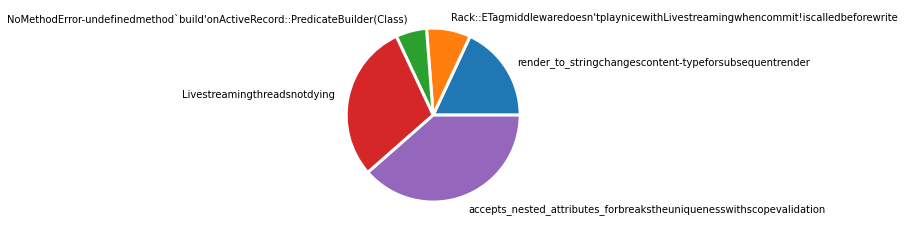

In [36]:
plt.pie(top_5_list_of_number_of_participants, labels=top_5_list_of_names, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' });